# Oceananigans-brackish
idealized simulation of buoyant freshwater entering salty water

In [1]:
using Pkg

Pkg.activate("..")

using CairoMakie
using Oceananigans
using OceanBioME
using Oceananigans.Units: meters
 
include("../includes/TracerLinearEquationOfState.jl");

  Activating project at `/nfs/roberts/project/pi_mt477/ljg48/cross-section-model`
┌ Warning: You are using Julia v1.11 or later!"
│ Oceananigans is currently tested on Julia v1.10."
│ If you find issues with Julia v1.11 or later,"
│ please report at https://github.com/CliMA/Oceananigans.jl/issues/new
└ @ Oceananigans ~/.julia/packages/Oceananigans/Xawvn/src/Oceananigans.jl:124


In [ ]:
using Pkg

Pkg.activate("..")

using CairoMakie
using Oceananigans
using OceanBioME
using Oceananigans.Units: meters
 
include("../includes/TracerLinearEquationOfState.jl");

# =======================================
# define architecture CPU or GPU
# =======================================
architecture = CPU()

# =======================================
# define model grid
# =======================================
x = (0, 15meters)
z = (-0.5meters, 0)
Δx, Δz = 0.01meters, 0.01meters
size = (Int(x[2]/Δx), Int(-z[1]/Δz))
topology = (Bounded, Flat, Bounded)

grid = RectilinearGrid(architecture; size, x, z, topology)


# =======================================
# Model paramters
# =======================================
closure = ScalarDiffusivity(ν=1e-6, κ=1e-6)
tracers = (:T, :S, :c)
coriolis = FPlane(f=0.2)
advection=WENO()

# ---------------------------------------
# equation of state and buoyancy
# b = g (- β S - γ C) # ignore temperature influence
# ---------------------------------------
eos = TracerLinearEquationOfState(thermal_expansion  = 0,     # turn off thermal expansin  
                                  haline_contraction = 0.76,  # change haline contraction
                                  tracer_contraction = 2.2,   
                                  reference_density  = 1000.0)

buoyancy = SeawaterBuoyancy(equation_of_state = eos)

model = NonhydrostaticModel(; grid, 
                              buoyancy,
                              tracers,
                              coriolis, 
                              advection, 
                              closure)


# =======================================
# set intial salinity and tracers
# =======================================
# function to get index closest to value
closest_index(target, collection) = argmin(abs.(collection .- target))

# create x and z collections
xᶜ = collect(grid.xᶜᵃᵃ)
zᶜ = collect(grid.z.cᵃᵃᶜ)

# find index range for x ∈ [0, 0.15] 
i₁ = closest_index(0.0,   xᶜ)
i₂ = closest_index(0.15,  xᶜ)

# find index range for z ∈ [-0.15, 0]
k₁ = closest_index(-0.15, zᶜ)
k₂ = closest_index(0.0,   zᶜ)

# create zero array on center grid
S_initial = CenterField(grid)
c_initial = CenterField(grid)

# set values within the index range
S_initial[i₁:i₂, :, k₁:k₂] .= 25.0;
c_initial[i₁:i₂, :, k₁:k₂] .= 0.0078;

# now se the values in the model
set!(model, T=25, S=S_initial, c = c_initial)


# set stuff

simulation = Simulation(model; Δt = 0.005, stop_iteration=10)

run!(simulation)

# cfl = 0.5
# current_speed = 0.1
# Δt = (cfl * dx) / current_speed # 0.05
#simulation = Simulation(model; Δt = 0.05, stop_iteration=1000)

# about 1 minute per 1000 iterations on CPU
# try running on GPU
# about 120,000 to run for 100 minutes
simulation.stop_iteration = 1000
simulation.Δt = 0.05
run!(simulation)


# Make simple plot

In [1]:
using Oceananigans

┌ Warning: You are using Julia v1.11 or later!"
│ Oceananigans is currently tested on Julia v1.10."
│ If you find issues with Julia v1.11 or later,"
│ please report at https://github.com/CliMA/Oceananigans.jl/issues/new
└ @ Oceananigans ~/.julia/packages/Oceananigans/Xawvn/src/Oceananigans.jl:124


In [2]:
AnisotropicMinimumDissipation()

AnisotropicMinimumDissipation{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization} turbulence closure with:
           Poincaré constant for momentum eddy viscosity Cν: 0.3333333333333333
    Poincaré constant for tracer(s) eddy diffusivit(ies) Cκ: 0.3333333333333333
                        Buoyancy modification multiplier Cb: nothing

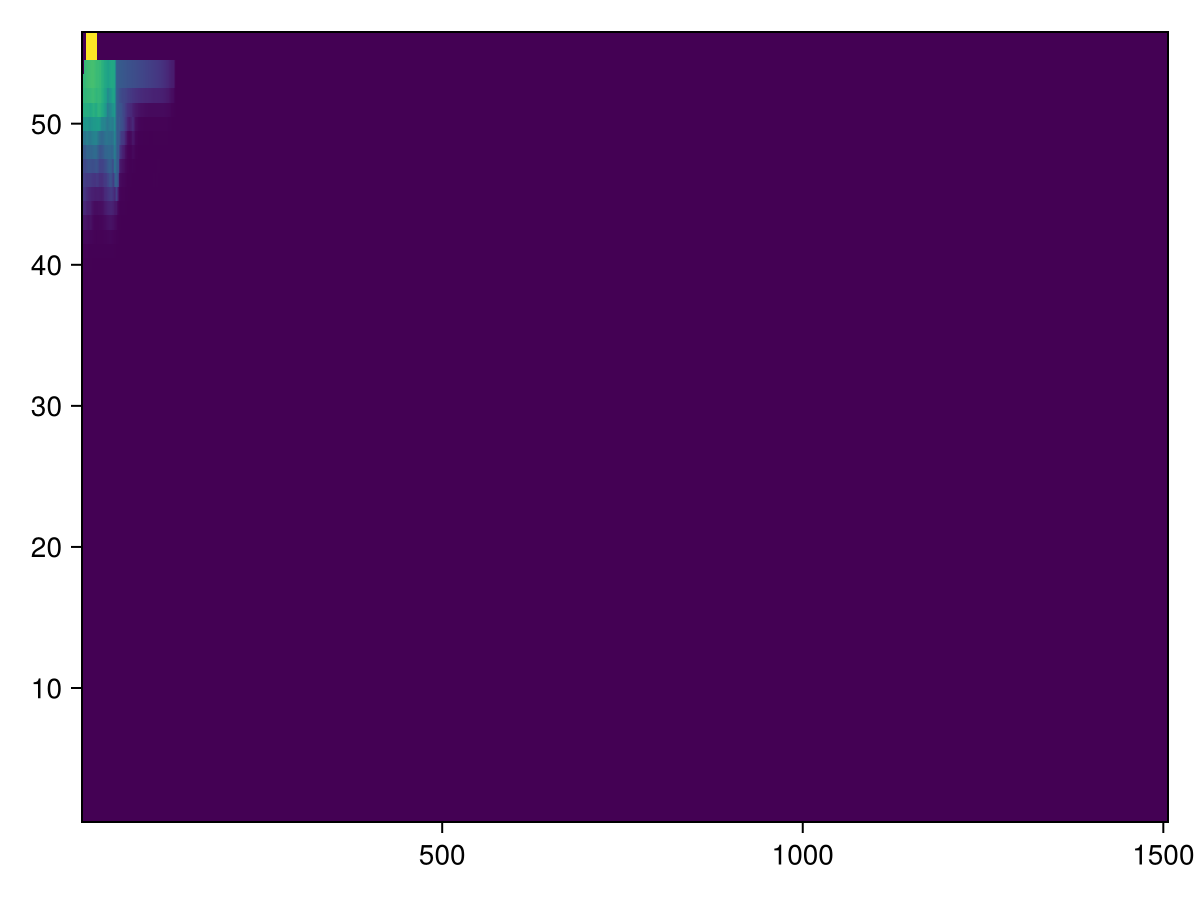

In [20]:
data = collect(simulation.model.tracers.c[:,1,:])

fig = Figure()
ax = Axis(fig[1, 1])
heatmap!(ax, data, colormap = :viridis)
fig